***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
image_dir = Path('./Imagenes/Trayectorias_dominio_tiempo_frecuencia/longitud_8/raw-img-v5')

file_paths = list(image_dir.rglob("*.jpg")) + \
             list(image_dir.rglob("*.jpeg")) + \
             list(image_dir.rglob("*.png"))

complete_df = pd.DataFrame()
complete_df['file_name'] = [str(p) for p in file_paths]
complete_df['class_name'] = complete_df['file_name'].map(lambda x: Path(x).parent.name)

### COMPROBACIÓN ###
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)


Número total de imágenes: 13668
class_name
AIS(37)       4160
AIS(31-32)    3260
AIS(70-79)    1216
AIS(90-99)    1058
AIS(36)       1014
AIS(60-69)     993
AIS(30)        896
AIS(80-89)     570
AIS(52)        310
AIS(56-57)     191
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 10937
class_name
AIS(37)       3328
AIS(31-32)    2608
AIS(70-79)     973
AIS(90-99)     847
AIS(36)        812
AIS(60-69)     795
AIS(30)        717
AIS(80-89)     456
AIS(52)        248
AIS(56-57)     153
Name: count, dtype: int64

Nº de imágenes en test: 2731
class_name
AIS(37)       832
AIS(31-32)    652
AIS(70-79)    243
AIS(90-99)    211
AIS(36)       202
AIS(60-69)    198
AIS(30)       179
AIS(80-89)    114
AIS(52)        62
AIS(56-57)     38
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name  class_name
0  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     AIS(37)
1  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  AIS(31-32)
2  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  AIS(60-69)
3  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     AIS(36)
4  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     AIS(37)
5  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  AIS(56-57)
6  Imagenes\Trayec

***Imágenes de entrenamiento y test antes del pre-procesado :***

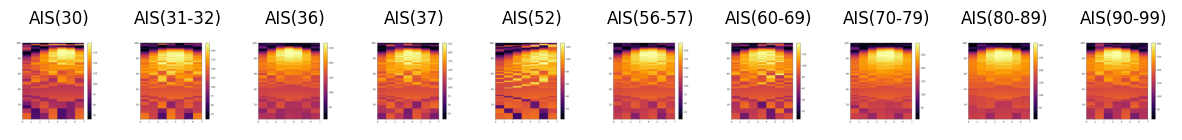

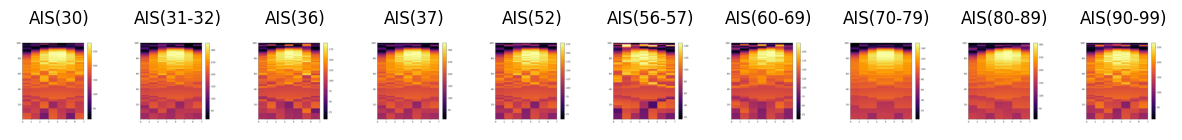

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    grouped = df.groupby('class_name')
    
    for i, (class_name, group) in enumerate(grouped):
        image_path = group['file_name'].iloc[0]
        image = Image.open(image_path).convert("RGB")
        
        plt.subplot(1, len(grouped), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])

def preprocesado_imagen(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

for index, row in train_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_train.append(image_tensor)
    y_train.append(row['class_name'])

for index, row in test_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_test.append(image_tensor)
    y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

### COMPROBACIÓN ###
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)


cuda disponible
X_train: torch.Size([10937, 3, 227, 227]) cpu
y_train: torch.Size([10937]) cpu
X_test: torch.Size([2731, 3, 227, 227]) cpu
y_test: torch.Size([2731]) cpu


# ***AlexNet :***

In [ ]:
def get_alexnet_model(num_classes, pretrained):
    if pretrained:
        modelo = alexnet(weights=AlexNet_Weights.DEFAULT)
    else:
        modelo = alexnet(weights=None)

    modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, num_classes)

    if pretrained:
        for param in modelo.features.parameters():
            param.requires_grad = False
            
        for param in modelo.classifier[6].parameters():
            param.requires_grad = True

    return modelo

# ***ResNet50 :***

In [6]:
def get_resnet50_model(num_classes, pretrained):
    if pretrained:
        modelo = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        modelo = resnet50(weights=None)

    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.fc.parameters():
            param.requires_grad = True

    return modelo

# ***DenseNet121 :***

In [6]:
def get_densenet121_model(num_classes, pretrained):
    if pretrained:
        modelo = densenet121(weights=DenseNet121_Weights.DEFAULT)
    else:
        modelo = densenet121(weights=None)

    modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier.parameters():
            param.requires_grad = True

    return modelo

# ***ConvNeXt Tiny :***

In [6]:
def get_convnext_tiny_model(num_classes, pretrained):
    if pretrained:
        modelo = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    else:
        modelo = convnext_tiny(weights=None)

    modelo.classifier[2] = nn.Linear(modelo.classifier[2].in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier[2].parameters():
            param.requires_grad = True

    return modelo

***Configuración del modelo :***

In [7]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

***Entrenamiento del modelo :***

In [8]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

    #nombre_modelo = "AlexNet"
    #modelo = get_alexnet_model(num_classes=num_classes, pretrained=False).to(device)
    
    #nombre_modelo = "ResNet50"
    #modelo = get_resnet50_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "DenseNet121"
    #modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)
    
    nombre_modelo = "ConvNext_Tiny"
    modelo = get_convnext_tiny_model(num_classes=num_classes, pretrained=True).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = modelo(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        modelo.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                output = modelo(images)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v5/representacion_3/longitud_8"
        os.makedirs(save_path, exist_ok=True)
        torch.save(modelo.state_dict(), f"{save_path}/{nombre_modelo}_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 274/274 [01:30<00:00,  3.03it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 12.08% - Train Loss: 2.3341 | Val Acc: 18.01% - Val Loss: 2.2847


Fold 1 | Epoch 2/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 12.86% - Train Loss: 2.3112 | Val Acc: 27.15% - Val Loss: 2.3251


Fold 1 | Epoch 3/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 14.06% - Train Loss: 2.3081 | Val Acc: 10.15% - Val Loss: 2.3128


Fold 1 | Epoch 4/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 15.22% - Train Loss: 2.2952 | Val Acc: 11.88% - Val Loss: 2.2869


Fold 1 | Epoch 5/100: 100%|██████████| 274/274 [01:05<00:00,  4.18it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 15.49% - Train Loss: 2.3017 | Val Acc: 10.15% - Val Loss: 2.2782


Fold 1 | Epoch 6/100: 100%|██████████| 274/274 [01:06<00:00,  4.15it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 15.70% - Train Loss: 2.2903 | Val Acc: 9.37% - Val Loss: 2.3050


Fold 1 | Epoch 7/100: 100%|██████████| 274/274 [01:04<00:00,  4.23it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 15.40% - Train Loss: 2.2833 | Val Acc: 12.02% - Val Loss: 2.2858


Fold 1 | Epoch 8/100: 100%|██████████| 274/274 [01:05<00:00,  4.21it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 16.57% - Train Loss: 2.2803 | Val Acc: 10.65% - Val Loss: 2.2735


Fold 1 | Epoch 9/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 15.67% - Train Loss: 2.2757 | Val Acc: 13.62% - Val Loss: 2.2939


Fold 1 | Epoch 10/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 17.22% - Train Loss: 2.2772 | Val Acc: 23.22% - Val Loss: 2.2683


Fold 1 | Epoch 11/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 16.23% - Train Loss: 2.2768 | Val Acc: 5.03% - Val Loss: 2.3064


Fold 1 | Epoch 12/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 16.56% - Train Loss: 2.2745 | Val Acc: 14.67% - Val Loss: 2.2734


Fold 1 | Epoch 13/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 16.96% - Train Loss: 2.2692 | Val Acc: 9.73% - Val Loss: 2.2933


Fold 1 | Epoch 14/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 16.98% - Train Loss: 2.2691 | Val Acc: 10.28% - Val Loss: 2.2695


Fold 1 | Epoch 15/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 17.89% - Train Loss: 2.2629 | Val Acc: 16.86% - Val Loss: 2.2545


Fold 1 | Epoch 16/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 16.88% - Train Loss: 2.2654 | Val Acc: 14.35% - Val Loss: 2.2644


Fold 1 | Epoch 17/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 16.30% - Train Loss: 2.2752 | Val Acc: 16.96% - Val Loss: 2.2632


Fold 1 | Epoch 18/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 17.40% - Train Loss: 2.2707 | Val Acc: 20.98% - Val Loss: 2.2708


Fold 1 | Epoch 19/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 17.52% - Train Loss: 2.2672 | Val Acc: 19.01% - Val Loss: 2.2543


Fold 1 | Epoch 20/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 18.14% - Train Loss: 2.2660 | Val Acc: 18.01% - Val Loss: 2.2417


Fold 1 | Epoch 21/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 17.35% - Train Loss: 2.2583 | Val Acc: 12.11% - Val Loss: 2.2975


Fold 1 | Epoch 22/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 16.76% - Train Loss: 2.2689 | Val Acc: 11.84% - Val Loss: 2.2649


Fold 1 | Epoch 23/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 17.40% - Train Loss: 2.2664 | Val Acc: 23.58% - Val Loss: 2.2496


Fold 1 | Epoch 24/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 17.93% - Train Loss: 2.2529 | Val Acc: 17.00% - Val Loss: 2.2467


Fold 1 | Epoch 25/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 18.32% - Train Loss: 2.2551 | Val Acc: 27.42% - Val Loss: 2.2680


Fold 1 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 17.12% - Train Loss: 2.2738 | Val Acc: 20.66% - Val Loss: 2.2912


Fold 1 | Epoch 27/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 18.13% - Train Loss: 2.2621 | Val Acc: 5.12% - Val Loss: 2.3945


Fold 1 | Epoch 28/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 17.61% - Train Loss: 2.2635 | Val Acc: 18.01% - Val Loss: 2.2532


Fold 1 | Epoch 29/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 17.62% - Train Loss: 2.2509 | Val Acc: 20.48% - Val Loss: 2.2427


Fold 1 | Epoch 30/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 17.22% - Train Loss: 2.2543 | Val Acc: 8.14% - Val Loss: 2.2945


Fold 1 | Epoch 31/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 17.21% - Train Loss: 2.2539 | Val Acc: 8.82% - Val Loss: 2.2848


Fold 1 | Epoch 32/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 16.79% - Train Loss: 2.2581 | Val Acc: 19.42% - Val Loss: 2.2643


Fold 1 | Epoch 33/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 17.49% - Train Loss: 2.2537 | Val Acc: 13.76% - Val Loss: 2.2632


Fold 1 | Epoch 34/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 17.65% - Train Loss: 2.2572 | Val Acc: 25.05% - Val Loss: 2.2710


Fold 1 | Epoch 35/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 18.22% - Train Loss: 2.2533 | Val Acc: 9.92% - Val Loss: 2.3507


Fold 1 | Epoch 36/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 18.23% - Train Loss: 2.2624 | Val Acc: 23.08% - Val Loss: 2.2503


Fold 1 | Epoch 37/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 17.92% - Train Loss: 2.2533 | Val Acc: 13.89% - Val Loss: 2.2495


Fold 1 | Epoch 38/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 18.17% - Train Loss: 2.2536 | Val Acc: 9.19% - Val Loss: 2.2591


Fold 1 | Epoch 39/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 17.72% - Train Loss: 2.2424 | Val Acc: 24.50% - Val Loss: 2.2749


Fold 1 | Epoch 40/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 17.77% - Train Loss: 2.2500 | Val Acc: 16.13% - Val Loss: 2.2638


Fold 1 | Epoch 41/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 18.57% - Train Loss: 2.2441 | Val Acc: 15.08% - Val Loss: 2.2404


Fold 1 | Epoch 42/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 17.97% - Train Loss: 2.2450 | Val Acc: 12.25% - Val Loss: 2.2897


Fold 1 | Epoch 43/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 17.19% - Train Loss: 2.2503 | Val Acc: 17.60% - Val Loss: 2.2858


Fold 1 | Epoch 44/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 18.25% - Train Loss: 2.2548 | Val Acc: 8.68% - Val Loss: 2.2667


Fold 1 | Epoch 45/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 17.68% - Train Loss: 2.2468 | Val Acc: 21.76% - Val Loss: 2.2743


Fold 1 | Epoch 46/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 18.74% - Train Loss: 2.2403 | Val Acc: 20.20% - Val Loss: 2.2696


Fold 1 | Epoch 47/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 19.11% - Train Loss: 2.2401 | Val Acc: 13.53% - Val Loss: 2.2658


Fold 1 | Epoch 48/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 18.01% - Train Loss: 2.2491 | Val Acc: 21.62% - Val Loss: 2.2360


Fold 1 | Epoch 49/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 17.78% - Train Loss: 2.2486 | Val Acc: 17.18% - Val Loss: 2.3139


Fold 1 | Epoch 50/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 18.44% - Train Loss: 2.2472 | Val Acc: 13.48% - Val Loss: 2.2991


Fold 1 | Epoch 51/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 18.16% - Train Loss: 2.2469 | Val Acc: 22.07% - Val Loss: 2.2742


Fold 1 | Epoch 52/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 18.31% - Train Loss: 2.2425 | Val Acc: 16.09% - Val Loss: 2.2665


Fold 1 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 17.16% - Train Loss: 2.2409 | Val Acc: 10.15% - Val Loss: 2.2602


Fold 1 | Epoch 54/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 18.50% - Train Loss: 2.2485 | Val Acc: 12.20% - Val Loss: 2.2524


Fold 1 | Epoch 55/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 17.91% - Train Loss: 2.2408 | Val Acc: 21.44% - Val Loss: 2.2517


Fold 1 | Epoch 56/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 18.83% - Train Loss: 2.2465 | Val Acc: 9.96% - Val Loss: 2.2614


Fold 1 | Epoch 57/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 19.02% - Train Loss: 2.2449 | Val Acc: 19.84% - Val Loss: 2.2731


Fold 1 | Epoch 58/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 17.99% - Train Loss: 2.2376 | Val Acc: 15.86% - Val Loss: 2.2579


Fold 1 | Epoch 59/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 19.17% - Train Loss: 2.2464 | Val Acc: 14.17% - Val Loss: 2.2545


Fold 1 | Epoch 60/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 19.13% - Train Loss: 2.2391 | Val Acc: 9.83% - Val Loss: 2.2620


Fold 1 | Epoch 61/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 18.02% - Train Loss: 2.2455 | Val Acc: 21.80% - Val Loss: 2.2674


Fold 1 | Epoch 62/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 17.76% - Train Loss: 2.2313 | Val Acc: 16.91% - Val Loss: 2.2835


Fold 1 | Epoch 63/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 17.40% - Train Loss: 2.2499 | Val Acc: 20.38% - Val Loss: 2.2672


Fold 1 | Epoch 64/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 18.83% - Train Loss: 2.2353 | Val Acc: 13.07% - Val Loss: 2.2493


Fold 1 | Epoch 65/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 17.60% - Train Loss: 2.2411 | Val Acc: 12.80% - Val Loss: 2.2821


Fold 1 | Epoch 66/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 17.81% - Train Loss: 2.2404 | Val Acc: 19.93% - Val Loss: 2.2487


Fold 1 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 19.18% - Train Loss: 2.2440 | Val Acc: 13.12% - Val Loss: 2.2701


Fold 1 | Epoch 68/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 17.35% - Train Loss: 2.2395 | Val Acc: 19.06% - Val Loss: 2.2795


Fold 1 | Epoch 69/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 18.40% - Train Loss: 2.2270 | Val Acc: 17.96% - Val Loss: 2.2501


Fold 1 | Epoch 70/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 18.72% - Train Loss: 2.2373 | Val Acc: 9.55% - Val Loss: 2.2900


Fold 1 | Epoch 71/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 17.78% - Train Loss: 2.2408 | Val Acc: 11.97% - Val Loss: 2.2731


Fold 1 | Epoch 72/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 17.90% - Train Loss: 2.2329 | Val Acc: 12.57% - Val Loss: 2.3377


Fold 1 | Epoch 73/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 20.22% - Train Loss: 2.2338 | Val Acc: 17.92% - Val Loss: 2.2493


Fold 1 | Epoch 74/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 18.41% - Train Loss: 2.2440 | Val Acc: 34.23% - Val Loss: 2.2875


Fold 1 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 18.87% - Train Loss: 2.2338 | Val Acc: 9.28% - Val Loss: 2.2788


Fold 1 | Epoch 76/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 18.33% - Train Loss: 2.2315 | Val Acc: 20.61% - Val Loss: 2.2560


Fold 1 | Epoch 77/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 17.56% - Train Loss: 2.2391 | Val Acc: 20.66% - Val Loss: 2.2452


Fold 1 | Epoch 78/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 18.16% - Train Loss: 2.2313 | Val Acc: 13.67% - Val Loss: 2.2524


Fold 1 | Epoch 79/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 17.02% - Train Loss: 2.2397 | Val Acc: 13.35% - Val Loss: 2.2934


Fold 1 | Epoch 80/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 18.36% - Train Loss: 2.2377 | Val Acc: 20.84% - Val Loss: 2.2621


Fold 1 | Epoch 81/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 19.11% - Train Loss: 2.2239 | Val Acc: 15.40% - Val Loss: 2.2701


Fold 1 | Epoch 82/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 17.58% - Train Loss: 2.2351 | Val Acc: 11.65% - Val Loss: 2.2920


Fold 1 | Epoch 83/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 18.42% - Train Loss: 2.2414 | Val Acc: 15.68% - Val Loss: 2.2554


Fold 1 | Epoch 84/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 19.17% - Train Loss: 2.2254 | Val Acc: 20.52% - Val Loss: 2.2791


Fold 1 | Epoch 85/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 19.52% - Train Loss: 2.2234 | Val Acc: 19.56% - Val Loss: 2.2430


Fold 1 | Epoch 86/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 19.19% - Train Loss: 2.2270 | Val Acc: 6.81% - Val Loss: 2.3291


Fold 1 | Epoch 87/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 18.17% - Train Loss: 2.2252 | Val Acc: 18.83% - Val Loss: 2.3048


Fold 1 | Epoch 88/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 18.72% - Train Loss: 2.2351 | Val Acc: 12.52% - Val Loss: 2.2922


Fold 1 | Epoch 89/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 19.04% - Train Loss: 2.2221 | Val Acc: 15.27% - Val Loss: 2.2697


Fold 1 | Epoch 90/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 18.61% - Train Loss: 2.2310 | Val Acc: 5.99% - Val Loss: 2.3109


Fold 1 | Epoch 91/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 17.89% - Train Loss: 2.2298 | Val Acc: 19.52% - Val Loss: 2.2777


Fold 1 | Epoch 92/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 18.80% - Train Loss: 2.2347 | Val Acc: 18.24% - Val Loss: 2.2705


Fold 1 | Epoch 93/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 19.03% - Train Loss: 2.2344 | Val Acc: 11.47% - Val Loss: 2.2770


Fold 1 | Epoch 94/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 18.40% - Train Loss: 2.2372 | Val Acc: 13.67% - Val Loss: 2.2721


Fold 1 | Epoch 95/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 19.93% - Train Loss: 2.2180 | Val Acc: 10.01% - Val Loss: 2.2900


Fold 1 | Epoch 96/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 18.01% - Train Loss: 2.2289 | Val Acc: 26.97% - Val Loss: 2.2862


Fold 1 | Epoch 97/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 19.48% - Train Loss: 2.2311 | Val Acc: 5.76% - Val Loss: 2.3277


Fold 1 | Epoch 98/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 18.91% - Train Loss: 2.2151 | Val Acc: 8.87% - Val Loss: 2.2799


Fold 1 | Epoch 99/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 19.09% - Train Loss: 2.2290 | Val Acc: 17.23% - Val Loss: 2.2633


Fold 1 | Epoch 100/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 19.31% - Train Loss: 2.2331 | Val Acc: 12.39% - Val Loss: 2.2505

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 10.66% - Train Loss: 2.3357 | Val Acc: 9.19% - Val Loss: 2.2869


Fold 2 | Epoch 2/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 13.40% - Train Loss: 2.3183 | Val Acc: 8.00% - Val Loss: 2.2934


Fold 2 | Epoch 3/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 12.60% - Train Loss: 2.3001 | Val Acc: 22.21% - Val Loss: 2.2718


Fold 2 | Epoch 4/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 14.31% - Train Loss: 2.3047 | Val Acc: 1.33% - Val Loss: 2.3638


Fold 2 | Epoch 5/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 13.76% - Train Loss: 2.2983 | Val Acc: 11.33% - Val Loss: 2.2741


Fold 2 | Epoch 6/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 14.89% - Train Loss: 2.2966 | Val Acc: 10.15% - Val Loss: 2.2742


Fold 2 | Epoch 7/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 16.33% - Train Loss: 2.2820 | Val Acc: 21.30% - Val Loss: 2.2720


Fold 2 | Epoch 8/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 16.45% - Train Loss: 2.2791 | Val Acc: 10.15% - Val Loss: 2.2596


Fold 2 | Epoch 9/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 16.45% - Train Loss: 2.2756 | Val Acc: 15.08% - Val Loss: 2.2762


Fold 2 | Epoch 10/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 16.28% - Train Loss: 2.2829 | Val Acc: 10.74% - Val Loss: 2.2893


Fold 2 | Epoch 11/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 15.89% - Train Loss: 2.2781 | Val Acc: 26.78% - Val Loss: 2.2701


Fold 2 | Epoch 12/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 15.62% - Train Loss: 2.2724 | Val Acc: 31.67% - Val Loss: 2.2987


Fold 2 | Epoch 13/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 16.09% - Train Loss: 2.2770 | Val Acc: 17.96% - Val Loss: 2.3121


Fold 2 | Epoch 14/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 16.60% - Train Loss: 2.2694 | Val Acc: 28.20% - Val Loss: 2.2622


Fold 2 | Epoch 15/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 16.86% - Train Loss: 2.2693 | Val Acc: 17.28% - Val Loss: 2.2832


Fold 2 | Epoch 16/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 16.53% - Train Loss: 2.2643 | Val Acc: 11.24% - Val Loss: 2.2629


Fold 2 | Epoch 17/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 15.85% - Train Loss: 2.2684 | Val Acc: 9.28% - Val Loss: 2.2629


Fold 2 | Epoch 18/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 15.70% - Train Loss: 2.2553 | Val Acc: 14.72% - Val Loss: 2.2666


Fold 2 | Epoch 19/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 16.61% - Train Loss: 2.2594 | Val Acc: 18.88% - Val Loss: 2.2648


Fold 2 | Epoch 20/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 16.48% - Train Loss: 2.2627 | Val Acc: 29.30% - Val Loss: 2.2442


Fold 2 | Epoch 21/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 15.88% - Train Loss: 2.2581 | Val Acc: 21.94% - Val Loss: 2.2420


Fold 2 | Epoch 22/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 18.55% - Train Loss: 2.2580 | Val Acc: 21.76% - Val Loss: 2.2647


Fold 2 | Epoch 23/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 15.94% - Train Loss: 2.2619 | Val Acc: 17.28% - Val Loss: 2.2528


Fold 2 | Epoch 24/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 17.45% - Train Loss: 2.2622 | Val Acc: 17.09% - Val Loss: 2.2722


Fold 2 | Epoch 25/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 16.37% - Train Loss: 2.2553 | Val Acc: 25.00% - Val Loss: 2.2765


Fold 2 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 18.36% - Train Loss: 2.2540 | Val Acc: 10.24% - Val Loss: 2.3017


Fold 2 | Epoch 27/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 16.66% - Train Loss: 2.2598 | Val Acc: 31.76% - Val Loss: 2.2602


Fold 2 | Epoch 28/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 17.41% - Train Loss: 2.2587 | Val Acc: 18.83% - Val Loss: 2.2442


Fold 2 | Epoch 29/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 16.30% - Train Loss: 2.2554 | Val Acc: 25.05% - Val Loss: 2.2767


Fold 2 | Epoch 30/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 17.70% - Train Loss: 2.2526 | Val Acc: 17.78% - Val Loss: 2.2449


Fold 2 | Epoch 31/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 17.18% - Train Loss: 2.2400 | Val Acc: 21.39% - Val Loss: 2.2764


Fold 2 | Epoch 32/100: 100%|██████████| 274/274 [01:03<00:00,  4.28it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 17.91% - Train Loss: 2.2654 | Val Acc: 23.54% - Val Loss: 2.2926


Fold 2 | Epoch 33/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 18.50% - Train Loss: 2.2571 | Val Acc: 14.21% - Val Loss: 2.2913


Fold 2 | Epoch 34/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 15.99% - Train Loss: 2.2550 | Val Acc: 19.88% - Val Loss: 2.2552


Fold 2 | Epoch 35/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 17.34% - Train Loss: 2.2498 | Val Acc: 14.63% - Val Loss: 2.2456


Fold 2 | Epoch 36/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 16.55% - Train Loss: 2.2566 | Val Acc: 24.18% - Val Loss: 2.2591


Fold 2 | Epoch 37/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 17.69% - Train Loss: 2.2505 | Val Acc: 20.61% - Val Loss: 2.2756


Fold 2 | Epoch 38/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 16.77% - Train Loss: 2.2568 | Val Acc: 22.30% - Val Loss: 2.2714


Fold 2 | Epoch 39/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 18.14% - Train Loss: 2.2560 | Val Acc: 29.39% - Val Loss: 2.2654


Fold 2 | Epoch 40/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 18.04% - Train Loss: 2.2452 | Val Acc: 15.49% - Val Loss: 2.2425


Fold 2 | Epoch 41/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 17.51% - Train Loss: 2.2526 | Val Acc: 22.53% - Val Loss: 2.2434


Fold 2 | Epoch 42/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 17.75% - Train Loss: 2.2491 | Val Acc: 11.84% - Val Loss: 2.2502


Fold 2 | Epoch 43/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 16.45% - Train Loss: 2.2464 | Val Acc: 20.48% - Val Loss: 2.3172


Fold 2 | Epoch 44/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 17.38% - Train Loss: 2.2592 | Val Acc: 17.50% - Val Loss: 2.2747


Fold 2 | Epoch 45/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 17.77% - Train Loss: 2.2393 | Val Acc: 21.62% - Val Loss: 2.2731


Fold 2 | Epoch 46/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 16.98% - Train Loss: 2.2465 | Val Acc: 9.73% - Val Loss: 2.2757


Fold 2 | Epoch 47/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 16.86% - Train Loss: 2.2467 | Val Acc: 26.33% - Val Loss: 2.2717


Fold 2 | Epoch 48/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 18.78% - Train Loss: 2.2472 | Val Acc: 25.37% - Val Loss: 2.2502


Fold 2 | Epoch 49/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 17.37% - Train Loss: 2.2443 | Val Acc: 18.60% - Val Loss: 2.2883


Fold 2 | Epoch 50/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 16.62% - Train Loss: 2.2501 | Val Acc: 20.66% - Val Loss: 2.2298


Fold 2 | Epoch 51/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 17.09% - Train Loss: 2.2447 | Val Acc: 17.50% - Val Loss: 2.2698


Fold 2 | Epoch 52/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 16.53% - Train Loss: 2.2539 | Val Acc: 11.56% - Val Loss: 2.2791


Fold 2 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 17.58% - Train Loss: 2.2455 | Val Acc: 12.98% - Val Loss: 2.2414


Fold 2 | Epoch 54/100: 100%|██████████| 274/274 [01:02<00:00,  4.42it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 16.72% - Train Loss: 2.2418 | Val Acc: 16.54% - Val Loss: 2.2435


Fold 2 | Epoch 55/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 16.70% - Train Loss: 2.2447 | Val Acc: 17.82% - Val Loss: 2.2730


Fold 2 | Epoch 56/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 17.17% - Train Loss: 2.2440 | Val Acc: 21.12% - Val Loss: 2.2477


Fold 2 | Epoch 57/100: 100%|██████████| 274/274 [01:04<00:00,  4.23it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 17.29% - Train Loss: 2.2421 | Val Acc: 18.78% - Val Loss: 2.3064


Fold 2 | Epoch 58/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 17.83% - Train Loss: 2.2367 | Val Acc: 24.86% - Val Loss: 2.3308


Fold 2 | Epoch 59/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 16.47% - Train Loss: 2.2389 | Val Acc: 13.76% - Val Loss: 2.2574


Fold 2 | Epoch 60/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 16.66% - Train Loss: 2.2374 | Val Acc: 10.42% - Val Loss: 2.2488


Fold 2 | Epoch 61/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 17.76% - Train Loss: 2.2397 | Val Acc: 11.70% - Val Loss: 2.2770


Fold 2 | Epoch 62/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 17.92% - Train Loss: 2.2378 | Val Acc: 13.48% - Val Loss: 2.2538


Fold 2 | Epoch 63/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 17.44% - Train Loss: 2.2442 | Val Acc: 18.78% - Val Loss: 2.2547


Fold 2 | Epoch 64/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 18.33% - Train Loss: 2.2349 | Val Acc: 23.90% - Val Loss: 2.2429


Fold 2 | Epoch 65/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 17.40% - Train Loss: 2.2431 | Val Acc: 15.27% - Val Loss: 2.2864


Fold 2 | Epoch 66/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 17.94% - Train Loss: 2.2364 | Val Acc: 24.13% - Val Loss: 2.2692


Fold 2 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 18.13% - Train Loss: 2.2387 | Val Acc: 11.06% - Val Loss: 2.3278


Fold 2 | Epoch 68/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 17.27% - Train Loss: 2.2483 | Val Acc: 12.84% - Val Loss: 2.2591


Fold 2 | Epoch 69/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 18.64% - Train Loss: 2.2395 | Val Acc: 19.88% - Val Loss: 2.2965


Fold 2 | Epoch 70/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 17.73% - Train Loss: 2.2487 | Val Acc: 24.45% - Val Loss: 2.2669


Fold 2 | Epoch 71/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 17.34% - Train Loss: 2.2427 | Val Acc: 23.22% - Val Loss: 2.2816


Fold 2 | Epoch 72/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 17.01% - Train Loss: 2.2364 | Val Acc: 15.63% - Val Loss: 2.2487


Fold 2 | Epoch 73/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 17.64% - Train Loss: 2.2400 | Val Acc: 31.08% - Val Loss: 2.2684


Fold 2 | Epoch 74/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 17.54% - Train Loss: 2.2266 | Val Acc: 20.66% - Val Loss: 2.2913


Fold 2 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 17.91% - Train Loss: 2.2340 | Val Acc: 22.21% - Val Loss: 2.2588


Fold 2 | Epoch 76/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 17.89% - Train Loss: 2.2256 | Val Acc: 31.95% - Val Loss: 2.2617


Fold 2 | Epoch 77/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 17.19% - Train Loss: 2.2358 | Val Acc: 13.03% - Val Loss: 2.2687


Fold 2 | Epoch 78/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 17.69% - Train Loss: 2.2388 | Val Acc: 20.93% - Val Loss: 2.2947


Fold 2 | Epoch 79/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 18.05% - Train Loss: 2.2285 | Val Acc: 14.81% - Val Loss: 2.2614


Fold 2 | Epoch 80/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 18.44% - Train Loss: 2.2362 | Val Acc: 13.48% - Val Loss: 2.2684


Fold 2 | Epoch 81/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 18.08% - Train Loss: 2.2396 | Val Acc: 22.99% - Val Loss: 2.2928


Fold 2 | Epoch 82/100: 100%|██████████| 274/274 [01:02<00:00,  4.42it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 17.97% - Train Loss: 2.2430 | Val Acc: 24.59% - Val Loss: 2.2709


Fold 2 | Epoch 83/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 17.84% - Train Loss: 2.2295 | Val Acc: 29.75% - Val Loss: 2.2521


Fold 2 | Epoch 84/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 18.84% - Train Loss: 2.2251 | Val Acc: 12.34% - Val Loss: 2.2814


Fold 2 | Epoch 85/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 18.38% - Train Loss: 2.2395 | Val Acc: 21.48% - Val Loss: 2.2468


Fold 2 | Epoch 86/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 17.81% - Train Loss: 2.2306 | Val Acc: 23.45% - Val Loss: 2.2719


Fold 2 | Epoch 87/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 18.00% - Train Loss: 2.2327 | Val Acc: 26.01% - Val Loss: 2.2602


Fold 2 | Epoch 88/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 17.85% - Train Loss: 2.2214 | Val Acc: 16.18% - Val Loss: 2.2858


Fold 2 | Epoch 89/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 17.61% - Train Loss: 2.2298 | Val Acc: 12.07% - Val Loss: 2.3024


Fold 2 | Epoch 90/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 18.45% - Train Loss: 2.2306 | Val Acc: 15.90% - Val Loss: 2.2637


Fold 2 | Epoch 91/100: 100%|██████████| 274/274 [01:04<00:00,  4.28it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 18.88% - Train Loss: 2.2248 | Val Acc: 15.95% - Val Loss: 2.2516


Fold 2 | Epoch 92/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 18.18% - Train Loss: 2.2322 | Val Acc: 28.43% - Val Loss: 2.2639


Fold 2 | Epoch 93/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 17.88% - Train Loss: 2.2284 | Val Acc: 21.39% - Val Loss: 2.2750


Fold 2 | Epoch 94/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 17.67% - Train Loss: 2.2252 | Val Acc: 28.98% - Val Loss: 2.2700


Fold 2 | Epoch 95/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 18.89% - Train Loss: 2.2286 | Val Acc: 21.30% - Val Loss: 2.2307


Fold 2 | Epoch 96/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 17.10% - Train Loss: 2.2221 | Val Acc: 27.83% - Val Loss: 2.2498


Fold 2 | Epoch 97/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 18.89% - Train Loss: 2.2279 | Val Acc: 10.19% - Val Loss: 2.2543


Fold 2 | Epoch 98/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 17.21% - Train Loss: 2.2307 | Val Acc: 18.51% - Val Loss: 2.2579


Fold 2 | Epoch 99/100: 100%|██████████| 274/274 [01:03<00:00,  4.28it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 19.17% - Train Loss: 2.2302 | Val Acc: 13.89% - Val Loss: 2.2595


Fold 2 | Epoch 100/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 18.94% - Train Loss: 2.2266 | Val Acc: 30.53% - Val Loss: 2.2518

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 10.80% - Train Loss: 2.3263 | Val Acc: 8.82% - Val Loss: 2.3060


Fold 3 | Epoch 2/100: 100%|██████████| 274/274 [01:02<00:00,  4.42it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 13.52% - Train Loss: 2.3045 | Val Acc: 18.88% - Val Loss: 2.2998


Fold 3 | Epoch 3/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 13.83% - Train Loss: 2.3143 | Val Acc: 10.61% - Val Loss: 2.2952


Fold 3 | Epoch 4/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 15.97% - Train Loss: 2.3027 | Val Acc: 10.29% - Val Loss: 2.2854


Fold 3 | Epoch 5/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 15.42% - Train Loss: 2.2861 | Val Acc: 16.78% - Val Loss: 2.2789


Fold 3 | Epoch 6/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 16.39% - Train Loss: 2.2772 | Val Acc: 27.11% - Val Loss: 2.2883


Fold 3 | Epoch 7/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 16.03% - Train Loss: 2.2854 | Val Acc: 8.14% - Val Loss: 2.2757


Fold 3 | Epoch 8/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 17.41% - Train Loss: 2.2726 | Val Acc: 23.41% - Val Loss: 2.2920


Fold 3 | Epoch 9/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 16.82% - Train Loss: 2.2749 | Val Acc: 9.65% - Val Loss: 2.3141


Fold 3 | Epoch 10/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 16.10% - Train Loss: 2.2767 | Val Acc: 32.51% - Val Loss: 2.3407


Fold 3 | Epoch 11/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 15.44% - Train Loss: 2.2798 | Val Acc: 25.24% - Val Loss: 2.2574


Fold 3 | Epoch 12/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 16.35% - Train Loss: 2.2617 | Val Acc: 19.16% - Val Loss: 2.2955


Fold 3 | Epoch 13/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 15.34% - Train Loss: 2.2750 | Val Acc: 27.34% - Val Loss: 2.3178


Fold 3 | Epoch 14/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 16.93% - Train Loss: 2.2648 | Val Acc: 8.14% - Val Loss: 2.2659


Fold 3 | Epoch 15/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 16.85% - Train Loss: 2.2689 | Val Acc: 22.18% - Val Loss: 2.2556


Fold 3 | Epoch 16/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 16.87% - Train Loss: 2.2666 | Val Acc: 29.04% - Val Loss: 2.2842


Fold 3 | Epoch 17/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 17.85% - Train Loss: 2.2573 | Val Acc: 8.00% - Val Loss: 2.3307


Fold 3 | Epoch 18/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 17.15% - Train Loss: 2.2640 | Val Acc: 12.89% - Val Loss: 2.2619


Fold 3 | Epoch 19/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 16.62% - Train Loss: 2.2592 | Val Acc: 12.12% - Val Loss: 2.2823


Fold 3 | Epoch 20/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 16.05% - Train Loss: 2.2691 | Val Acc: 20.80% - Val Loss: 2.2823


Fold 3 | Epoch 21/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 17.77% - Train Loss: 2.2597 | Val Acc: 18.29% - Val Loss: 2.2699


Fold 3 | Epoch 22/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 17.25% - Train Loss: 2.2685 | Val Acc: 13.21% - Val Loss: 2.3081


Fold 3 | Epoch 23/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 17.53% - Train Loss: 2.2654 | Val Acc: 10.47% - Val Loss: 2.2560


Fold 3 | Epoch 24/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 16.93% - Train Loss: 2.2592 | Val Acc: 29.68% - Val Loss: 2.2859


Fold 3 | Epoch 25/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 17.73% - Train Loss: 2.2563 | Val Acc: 29.81% - Val Loss: 2.2678


Fold 3 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 18.38% - Train Loss: 2.2556 | Val Acc: 11.07% - Val Loss: 2.2580


Fold 3 | Epoch 27/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 17.04% - Train Loss: 2.2615 | Val Acc: 14.81% - Val Loss: 2.2696


Fold 3 | Epoch 28/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 17.76% - Train Loss: 2.2511 | Val Acc: 20.67% - Val Loss: 2.3018


Fold 3 | Epoch 29/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 17.42% - Train Loss: 2.2558 | Val Acc: 9.69% - Val Loss: 2.2698


Fold 3 | Epoch 30/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 17.28% - Train Loss: 2.2541 | Val Acc: 23.96% - Val Loss: 2.2587


Fold 3 | Epoch 31/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 18.18% - Train Loss: 2.2477 | Val Acc: 33.93% - Val Loss: 2.2757


Fold 3 | Epoch 32/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 16.61% - Train Loss: 2.2557 | Val Acc: 20.80% - Val Loss: 2.2701


Fold 3 | Epoch 33/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 17.26% - Train Loss: 2.2411 | Val Acc: 18.38% - Val Loss: 2.3181


Fold 3 | Epoch 34/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 18.06% - Train Loss: 2.2435 | Val Acc: 24.05% - Val Loss: 2.2918


Fold 3 | Epoch 35/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 17.85% - Train Loss: 2.2477 | Val Acc: 8.37% - Val Loss: 2.2699


Fold 3 | Epoch 36/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 17.20% - Train Loss: 2.2472 | Val Acc: 20.03% - Val Loss: 2.2687


Fold 3 | Epoch 37/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 18.73% - Train Loss: 2.2436 | Val Acc: 17.42% - Val Loss: 2.2646


Fold 3 | Epoch 38/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 19.54% - Train Loss: 2.2470 | Val Acc: 13.53% - Val Loss: 2.2649


Fold 3 | Epoch 39/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 17.85% - Train Loss: 2.2483 | Val Acc: 20.03% - Val Loss: 2.2621


Fold 3 | Epoch 40/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 18.43% - Train Loss: 2.2533 | Val Acc: 29.90% - Val Loss: 2.3101


Fold 3 | Epoch 41/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 18.05% - Train Loss: 2.2491 | Val Acc: 22.86% - Val Loss: 2.2707


Fold 3 | Epoch 42/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 18.14% - Train Loss: 2.2468 | Val Acc: 5.21% - Val Loss: 2.3082


Fold 3 | Epoch 43/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 17.62% - Train Loss: 2.2327 | Val Acc: 25.61% - Val Loss: 2.2601


Fold 3 | Epoch 44/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 18.94% - Train Loss: 2.2478 | Val Acc: 14.49% - Val Loss: 2.2637


Fold 3 | Epoch 45/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 18.23% - Train Loss: 2.2520 | Val Acc: 13.08% - Val Loss: 2.2518


Fold 3 | Epoch 46/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 17.97% - Train Loss: 2.2422 | Val Acc: 17.38% - Val Loss: 2.2741


Fold 3 | Epoch 47/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 18.70% - Train Loss: 2.2481 | Val Acc: 23.14% - Val Loss: 2.2652


Fold 3 | Epoch 48/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 17.66% - Train Loss: 2.2397 | Val Acc: 34.93% - Val Loss: 2.2758


Fold 3 | Epoch 49/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 18.13% - Train Loss: 2.2396 | Val Acc: 34.71% - Val Loss: 2.2935


Fold 3 | Epoch 50/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 17.89% - Train Loss: 2.2472 | Val Acc: 22.86% - Val Loss: 2.2615


Fold 3 | Epoch 51/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 17.46% - Train Loss: 2.2338 | Val Acc: 19.43% - Val Loss: 2.2614


Fold 3 | Epoch 52/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 18.24% - Train Loss: 2.2357 | Val Acc: 16.83% - Val Loss: 2.2992


Fold 3 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 18.72% - Train Loss: 2.2355 | Val Acc: 15.45% - Val Loss: 2.2823


Fold 3 | Epoch 54/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 18.69% - Train Loss: 2.2447 | Val Acc: 5.08% - Val Loss: 2.3043


Fold 3 | Epoch 55/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 17.31% - Train Loss: 2.2522 | Val Acc: 31.78% - Val Loss: 2.2768


Fold 3 | Epoch 56/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 20.37% - Train Loss: 2.2336 | Val Acc: 21.95% - Val Loss: 2.2541


Fold 3 | Epoch 57/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 19.39% - Train Loss: 2.2364 | Val Acc: 10.84% - Val Loss: 2.2596


Fold 3 | Epoch 58/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 17.63% - Train Loss: 2.2428 | Val Acc: 13.85% - Val Loss: 2.2527


Fold 3 | Epoch 59/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 17.79% - Train Loss: 2.2401 | Val Acc: 12.16% - Val Loss: 2.2913


Fold 3 | Epoch 60/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 18.79% - Train Loss: 2.2421 | Val Acc: 10.61% - Val Loss: 2.2516


Fold 3 | Epoch 61/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 17.76% - Train Loss: 2.2376 | Val Acc: 10.06% - Val Loss: 2.2669


Fold 3 | Epoch 62/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 18.75% - Train Loss: 2.2476 | Val Acc: 30.09% - Val Loss: 2.2649


Fold 3 | Epoch 63/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 18.61% - Train Loss: 2.2330 | Val Acc: 16.92% - Val Loss: 2.2870


Fold 3 | Epoch 64/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 18.37% - Train Loss: 2.2372 | Val Acc: 7.54% - Val Loss: 2.2927


Fold 3 | Epoch 65/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 17.60% - Train Loss: 2.2484 | Val Acc: 21.90% - Val Loss: 2.3306


Fold 3 | Epoch 66/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 18.69% - Train Loss: 2.2351 | Val Acc: 15.23% - Val Loss: 2.2649


Fold 3 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 19.57% - Train Loss: 2.2342 | Val Acc: 16.74% - Val Loss: 2.2473


Fold 3 | Epoch 68/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 18.93% - Train Loss: 2.2382 | Val Acc: 26.06% - Val Loss: 2.2514


Fold 3 | Epoch 69/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 17.03% - Train Loss: 2.2459 | Val Acc: 15.96% - Val Loss: 2.2550


Fold 3 | Epoch 70/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 19.47% - Train Loss: 2.2296 | Val Acc: 15.55% - Val Loss: 2.2537


Fold 3 | Epoch 71/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 18.49% - Train Loss: 2.2275 | Val Acc: 21.12% - Val Loss: 2.2682


Fold 3 | Epoch 72/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 17.47% - Train Loss: 2.2410 | Val Acc: 16.78% - Val Loss: 2.2805


Fold 3 | Epoch 73/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 18.75% - Train Loss: 2.2355 | Val Acc: 16.87% - Val Loss: 2.2609


Fold 3 | Epoch 74/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 18.97% - Train Loss: 2.2282 | Val Acc: 12.30% - Val Loss: 2.3127


Fold 3 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 19.03% - Train Loss: 2.2335 | Val Acc: 8.82% - Val Loss: 2.2692


Fold 3 | Epoch 76/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 19.19% - Train Loss: 2.2368 | Val Acc: 16.42% - Val Loss: 2.2616


Fold 3 | Epoch 77/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 18.37% - Train Loss: 2.2427 | Val Acc: 13.12% - Val Loss: 2.2708


Fold 3 | Epoch 78/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 19.01% - Train Loss: 2.2295 | Val Acc: 19.66% - Val Loss: 2.2790


Fold 3 | Epoch 79/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 18.61% - Train Loss: 2.2266 | Val Acc: 14.54% - Val Loss: 2.3136


Fold 3 | Epoch 80/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 18.83% - Train Loss: 2.2404 | Val Acc: 20.30% - Val Loss: 2.2942


Fold 3 | Epoch 81/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 18.74% - Train Loss: 2.2353 | Val Acc: 24.05% - Val Loss: 2.2937


Fold 3 | Epoch 82/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 17.94% - Train Loss: 2.2322 | Val Acc: 14.31% - Val Loss: 2.2643


Fold 3 | Epoch 83/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 18.14% - Train Loss: 2.2380 | Val Acc: 10.24% - Val Loss: 2.2938


Fold 3 | Epoch 84/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 18.51% - Train Loss: 2.2347 | Val Acc: 19.57% - Val Loss: 2.2611


Fold 3 | Epoch 85/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 19.51% - Train Loss: 2.2249 | Val Acc: 8.60% - Val Loss: 2.2763


Fold 3 | Epoch 86/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 17.92% - Train Loss: 2.2337 | Val Acc: 20.30% - Val Loss: 2.2619


Fold 3 | Epoch 87/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 18.08% - Train Loss: 2.2334 | Val Acc: 11.71% - Val Loss: 2.2841


Fold 3 | Epoch 88/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 18.32% - Train Loss: 2.2268 | Val Acc: 16.10% - Val Loss: 2.2494


Fold 3 | Epoch 89/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 18.49% - Train Loss: 2.2291 | Val Acc: 9.05% - Val Loss: 2.2916


Fold 3 | Epoch 90/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 19.19% - Train Loss: 2.2262 | Val Acc: 12.21% - Val Loss: 2.2648


Fold 3 | Epoch 91/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 18.88% - Train Loss: 2.2233 | Val Acc: 15.78% - Val Loss: 2.2452


Fold 3 | Epoch 92/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 18.45% - Train Loss: 2.2353 | Val Acc: 8.55% - Val Loss: 2.3446


Fold 3 | Epoch 93/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 18.19% - Train Loss: 2.2370 | Val Acc: 12.07% - Val Loss: 2.2817


Fold 3 | Epoch 94/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 19.23% - Train Loss: 2.2239 | Val Acc: 8.82% - Val Loss: 2.2721


Fold 3 | Epoch 95/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 19.69% - Train Loss: 2.2251 | Val Acc: 17.83% - Val Loss: 2.2799


Fold 3 | Epoch 96/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 17.51% - Train Loss: 2.2234 | Val Acc: 25.42% - Val Loss: 2.2643


Fold 3 | Epoch 97/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 19.55% - Train Loss: 2.2364 | Val Acc: 10.06% - Val Loss: 2.2708


Fold 3 | Epoch 98/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 18.05% - Train Loss: 2.2260 | Val Acc: 19.25% - Val Loss: 2.2719


Fold 3 | Epoch 99/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 18.15% - Train Loss: 2.2253 | Val Acc: 18.06% - Val Loss: 2.2643


Fold 3 | Epoch 100/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 19.19% - Train Loss: 2.2168 | Val Acc: 23.46% - Val Loss: 2.2553

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 11.13% - Train Loss: 2.3409 | Val Acc: 4.16% - Val Loss: 2.3452


Fold 4 | Epoch 2/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 12.58% - Train Loss: 2.3153 | Val Acc: 8.55% - Val Loss: 2.2804


Fold 4 | Epoch 3/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 13.01% - Train Loss: 2.3094 | Val Acc: 18.61% - Val Loss: 2.2644


Fold 4 | Epoch 4/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 13.13% - Train Loss: 2.3006 | Val Acc: 7.64% - Val Loss: 2.2731


Fold 4 | Epoch 5/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 14.46% - Train Loss: 2.2898 | Val Acc: 9.10% - Val Loss: 2.2884


Fold 4 | Epoch 6/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 12.87% - Train Loss: 2.2847 | Val Acc: 9.33% - Val Loss: 2.3358


Fold 4 | Epoch 7/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 14.63% - Train Loss: 2.2829 | Val Acc: 27.71% - Val Loss: 2.2704


Fold 4 | Epoch 8/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 15.63% - Train Loss: 2.2860 | Val Acc: 22.31% - Val Loss: 2.2587


Fold 4 | Epoch 9/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 14.41% - Train Loss: 2.2763 | Val Acc: 7.73% - Val Loss: 2.2736


Fold 4 | Epoch 10/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 15.09% - Train Loss: 2.2719 | Val Acc: 12.71% - Val Loss: 2.2745


Fold 4 | Epoch 11/100: 100%|██████████| 274/274 [01:01<00:00,  4.42it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 15.47% - Train Loss: 2.2778 | Val Acc: 7.86% - Val Loss: 2.2732


Fold 4 | Epoch 12/100: 100%|██████████| 274/274 [01:01<00:00,  4.43it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 16.00% - Train Loss: 2.2719 | Val Acc: 12.03% - Val Loss: 2.2650


Fold 4 | Epoch 13/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 15.71% - Train Loss: 2.2729 | Val Acc: 10.97% - Val Loss: 2.2684


Fold 4 | Epoch 14/100: 100%|██████████| 274/274 [01:02<00:00,  4.42it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 15.28% - Train Loss: 2.2744 | Val Acc: 8.78% - Val Loss: 2.2820


Fold 4 | Epoch 15/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 15.82% - Train Loss: 2.2699 | Val Acc: 15.27% - Val Loss: 2.2633


Fold 4 | Epoch 16/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 15.70% - Train Loss: 2.2704 | Val Acc: 22.68% - Val Loss: 2.2886


Fold 4 | Epoch 17/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 16.06% - Train Loss: 2.2702 | Val Acc: 8.82% - Val Loss: 2.2578


Fold 4 | Epoch 18/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 16.08% - Train Loss: 2.2633 | Val Acc: 11.11% - Val Loss: 2.2736


Fold 4 | Epoch 19/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 17.05% - Train Loss: 2.2679 | Val Acc: 11.93% - Val Loss: 2.2785


Fold 4 | Epoch 20/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 15.71% - Train Loss: 2.2729 | Val Acc: 7.13% - Val Loss: 2.2903


Fold 4 | Epoch 21/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 15.39% - Train Loss: 2.2641 | Val Acc: 20.30% - Val Loss: 2.2439


Fold 4 | Epoch 22/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 15.84% - Train Loss: 2.2588 | Val Acc: 8.50% - Val Loss: 2.2825


Fold 4 | Epoch 23/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 15.37% - Train Loss: 2.2535 | Val Acc: 6.17% - Val Loss: 2.2777


Fold 4 | Epoch 24/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 15.58% - Train Loss: 2.2562 | Val Acc: 6.90% - Val Loss: 2.2739


Fold 4 | Epoch 25/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 16.50% - Train Loss: 2.2636 | Val Acc: 21.12% - Val Loss: 2.3154


Fold 4 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 15.92% - Train Loss: 2.2759 | Val Acc: 25.61% - Val Loss: 2.2711


Fold 4 | Epoch 27/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 16.03% - Train Loss: 2.2545 | Val Acc: 10.38% - Val Loss: 2.2988


Fold 4 | Epoch 28/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 15.99% - Train Loss: 2.2643 | Val Acc: 21.54% - Val Loss: 2.2455


Fold 4 | Epoch 29/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 16.88% - Train Loss: 2.2537 | Val Acc: 18.88% - Val Loss: 2.2737


Fold 4 | Epoch 30/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 16.97% - Train Loss: 2.2542 | Val Acc: 12.71% - Val Loss: 2.2572


Fold 4 | Epoch 31/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 17.38% - Train Loss: 2.2542 | Val Acc: 7.00% - Val Loss: 2.2807


Fold 4 | Epoch 32/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 17.15% - Train Loss: 2.2530 | Val Acc: 10.24% - Val Loss: 2.3164


Fold 4 | Epoch 33/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 16.32% - Train Loss: 2.2602 | Val Acc: 16.87% - Val Loss: 2.2734


Fold 4 | Epoch 34/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 17.34% - Train Loss: 2.2517 | Val Acc: 28.58% - Val Loss: 2.2503


Fold 4 | Epoch 35/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 15.42% - Train Loss: 2.2552 | Val Acc: 16.60% - Val Loss: 2.2759


Fold 4 | Epoch 36/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 15.53% - Train Loss: 2.2646 | Val Acc: 11.29% - Val Loss: 2.2569


Fold 4 | Epoch 37/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 16.83% - Train Loss: 2.2514 | Val Acc: 13.44% - Val Loss: 2.3049


Fold 4 | Epoch 38/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 16.26% - Train Loss: 2.2561 | Val Acc: 14.17% - Val Loss: 2.2702


Fold 4 | Epoch 39/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 16.30% - Train Loss: 2.2515 | Val Acc: 36.90% - Val Loss: 2.2675


Fold 4 | Epoch 40/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 17.06% - Train Loss: 2.2502 | Val Acc: 15.82% - Val Loss: 2.2401


Fold 4 | Epoch 41/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 16.85% - Train Loss: 2.2548 | Val Acc: 28.53% - Val Loss: 2.2628


Fold 4 | Epoch 42/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 16.26% - Train Loss: 2.2465 | Val Acc: 18.20% - Val Loss: 2.2773


Fold 4 | Epoch 43/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 16.99% - Train Loss: 2.2514 | Val Acc: 11.20% - Val Loss: 2.2664


Fold 4 | Epoch 44/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 16.34% - Train Loss: 2.2507 | Val Acc: 21.08% - Val Loss: 2.2835


Fold 4 | Epoch 45/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 16.81% - Train Loss: 2.2428 | Val Acc: 18.52% - Val Loss: 2.2697


Fold 4 | Epoch 46/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 17.39% - Train Loss: 2.2411 | Val Acc: 18.61% - Val Loss: 2.2878


Fold 4 | Epoch 47/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 16.46% - Train Loss: 2.2556 | Val Acc: 16.32% - Val Loss: 2.2632


Fold 4 | Epoch 48/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 17.15% - Train Loss: 2.2494 | Val Acc: 10.65% - Val Loss: 2.2680


Fold 4 | Epoch 49/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 18.07% - Train Loss: 2.2420 | Val Acc: 23.64% - Val Loss: 2.2536


Fold 4 | Epoch 50/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 17.79% - Train Loss: 2.2450 | Val Acc: 14.22% - Val Loss: 2.2606


Fold 4 | Epoch 51/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 16.99% - Train Loss: 2.2462 | Val Acc: 21.72% - Val Loss: 2.2793


Fold 4 | Epoch 52/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 17.02% - Train Loss: 2.2438 | Val Acc: 20.53% - Val Loss: 2.2780


Fold 4 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 17.28% - Train Loss: 2.2529 | Val Acc: 28.12% - Val Loss: 2.2880


Fold 4 | Epoch 54/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 15.23% - Train Loss: 2.2460 | Val Acc: 25.47% - Val Loss: 2.2640


Fold 4 | Epoch 55/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 17.29% - Train Loss: 2.2392 | Val Acc: 14.04% - Val Loss: 2.2960


Fold 4 | Epoch 56/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 16.13% - Train Loss: 2.2483 | Val Acc: 28.49% - Val Loss: 2.2576


Fold 4 | Epoch 57/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 16.86% - Train Loss: 2.2325 | Val Acc: 11.02% - Val Loss: 2.3620


Fold 4 | Epoch 58/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 16.67% - Train Loss: 2.2384 | Val Acc: 15.00% - Val Loss: 2.2618


Fold 4 | Epoch 59/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 16.86% - Train Loss: 2.2431 | Val Acc: 24.74% - Val Loss: 2.2532


Fold 4 | Epoch 60/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 17.37% - Train Loss: 2.2462 | Val Acc: 9.56% - Val Loss: 2.2617


Fold 4 | Epoch 61/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 17.46% - Train Loss: 2.2338 | Val Acc: 23.96% - Val Loss: 2.2379


Fold 4 | Epoch 62/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 17.47% - Train Loss: 2.2428 | Val Acc: 12.94% - Val Loss: 2.3121


Fold 4 | Epoch 63/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 18.02% - Train Loss: 2.2363 | Val Acc: 20.35% - Val Loss: 2.2608


Fold 4 | Epoch 64/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 16.02% - Train Loss: 2.2390 | Val Acc: 15.45% - Val Loss: 2.2830


Fold 4 | Epoch 65/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 16.85% - Train Loss: 2.2366 | Val Acc: 23.55% - Val Loss: 2.2740


Fold 4 | Epoch 66/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 16.93% - Train Loss: 2.2432 | Val Acc: 17.38% - Val Loss: 2.2669


Fold 4 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 16.90% - Train Loss: 2.2433 | Val Acc: 23.78% - Val Loss: 2.2594


Fold 4 | Epoch 68/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 16.69% - Train Loss: 2.2380 | Val Acc: 16.51% - Val Loss: 2.2979


Fold 4 | Epoch 69/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 17.20% - Train Loss: 2.2421 | Val Acc: 15.91% - Val Loss: 2.2736


Fold 4 | Epoch 70/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 17.43% - Train Loss: 2.2266 | Val Acc: 17.51% - Val Loss: 2.2512


Fold 4 | Epoch 71/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 16.70% - Train Loss: 2.2278 | Val Acc: 8.50% - Val Loss: 2.3062


Fold 4 | Epoch 72/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 17.19% - Train Loss: 2.2376 | Val Acc: 21.54% - Val Loss: 2.2959


Fold 4 | Epoch 73/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 17.28% - Train Loss: 2.2426 | Val Acc: 17.42% - Val Loss: 2.2927


Fold 4 | Epoch 74/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 17.22% - Train Loss: 2.2361 | Val Acc: 21.40% - Val Loss: 2.2536


Fold 4 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 16.96% - Train Loss: 2.2400 | Val Acc: 26.75% - Val Loss: 2.2614


Fold 4 | Epoch 76/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 18.17% - Train Loss: 2.2293 | Val Acc: 22.13% - Val Loss: 2.2928


Fold 4 | Epoch 77/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 17.82% - Train Loss: 2.2254 | Val Acc: 11.29% - Val Loss: 2.2675


Fold 4 | Epoch 78/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 17.63% - Train Loss: 2.2374 | Val Acc: 15.32% - Val Loss: 2.2687


Fold 4 | Epoch 79/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 16.15% - Train Loss: 2.2471 | Val Acc: 28.94% - Val Loss: 2.2424


Fold 4 | Epoch 80/100: 100%|██████████| 274/274 [01:04<00:00,  4.27it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 16.78% - Train Loss: 2.2426 | Val Acc: 8.92% - Val Loss: 2.2859


Fold 4 | Epoch 81/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 16.59% - Train Loss: 2.2408 | Val Acc: 30.32% - Val Loss: 2.2410


Fold 4 | Epoch 82/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 17.97% - Train Loss: 2.2329 | Val Acc: 13.17% - Val Loss: 2.2663


Fold 4 | Epoch 83/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 17.94% - Train Loss: 2.2311 | Val Acc: 24.46% - Val Loss: 2.2508


Fold 4 | Epoch 84/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 17.07% - Train Loss: 2.2374 | Val Acc: 22.45% - Val Loss: 2.2745


Fold 4 | Epoch 85/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 17.20% - Train Loss: 2.2254 | Val Acc: 14.31% - Val Loss: 2.3372


Fold 4 | Epoch 86/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 16.63% - Train Loss: 2.2382 | Val Acc: 17.56% - Val Loss: 2.2667


Fold 4 | Epoch 87/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 18.99% - Train Loss: 2.2346 | Val Acc: 20.53% - Val Loss: 2.2778


Fold 4 | Epoch 88/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 17.01% - Train Loss: 2.2336 | Val Acc: 27.89% - Val Loss: 2.3470


Fold 4 | Epoch 89/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 17.82% - Train Loss: 2.2356 | Val Acc: 16.23% - Val Loss: 2.2708


Fold 4 | Epoch 90/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 17.62% - Train Loss: 2.2283 | Val Acc: 15.50% - Val Loss: 2.2558


Fold 4 | Epoch 91/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 18.00% - Train Loss: 2.2231 | Val Acc: 12.62% - Val Loss: 2.2839


Fold 4 | Epoch 92/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 17.19% - Train Loss: 2.2284 | Val Acc: 15.09% - Val Loss: 2.2893


Fold 4 | Epoch 93/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 17.29% - Train Loss: 2.2257 | Val Acc: 22.31% - Val Loss: 2.2599


Fold 4 | Epoch 94/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 17.99% - Train Loss: 2.2192 | Val Acc: 8.00% - Val Loss: 2.2934


Fold 4 | Epoch 95/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 17.15% - Train Loss: 2.2329 | Val Acc: 32.83% - Val Loss: 2.2468


Fold 4 | Epoch 96/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 17.91% - Train Loss: 2.2293 | Val Acc: 18.98% - Val Loss: 2.2688


Fold 4 | Epoch 97/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 17.73% - Train Loss: 2.2251 | Val Acc: 11.98% - Val Loss: 2.2816


Fold 4 | Epoch 98/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 17.09% - Train Loss: 2.2345 | Val Acc: 19.89% - Val Loss: 2.2773


Fold 4 | Epoch 99/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 16.63% - Train Loss: 2.2333 | Val Acc: 27.48% - Val Loss: 2.2611


Fold 4 | Epoch 100/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 17.10% - Train Loss: 2.2235 | Val Acc: 31.32% - Val Loss: 2.2788

📂 Fold 5/5


Fold 5 | Epoch 1/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 11.12% - Train Loss: 2.3327 | Val Acc: 8.64% - Val Loss: 2.3028


Fold 5 | Epoch 2/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 13.60% - Train Loss: 2.3191 | Val Acc: 10.01% - Val Loss: 2.2647


Fold 5 | Epoch 3/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 14.08% - Train Loss: 2.3036 | Val Acc: 16.87% - Val Loss: 2.2646


Fold 5 | Epoch 4/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 15.75% - Train Loss: 2.2991 | Val Acc: 25.01% - Val Loss: 2.3054


Fold 5 | Epoch 5/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 15.46% - Train Loss: 2.2872 | Val Acc: 26.34% - Val Loss: 2.2619


Fold 5 | Epoch 6/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 16.07% - Train Loss: 2.2895 | Val Acc: 5.30% - Val Loss: 2.3241


Fold 5 | Epoch 7/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 15.28% - Train Loss: 2.2822 | Val Acc: 16.87% - Val Loss: 2.2737


Fold 5 | Epoch 8/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 14.69% - Train Loss: 2.2924 | Val Acc: 15.23% - Val Loss: 2.2902


Fold 5 | Epoch 9/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 13.75% - Train Loss: 2.2849 | Val Acc: 24.33% - Val Loss: 2.2358


Fold 5 | Epoch 10/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 17.05% - Train Loss: 2.2761 | Val Acc: 30.91% - Val Loss: 2.3039


Fold 5 | Epoch 11/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 16.91% - Train Loss: 2.2786 | Val Acc: 15.00% - Val Loss: 2.2606


Fold 5 | Epoch 12/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 15.95% - Train Loss: 2.2815 | Val Acc: 11.43% - Val Loss: 2.2833


Fold 5 | Epoch 13/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 15.55% - Train Loss: 2.2759 | Val Acc: 23.32% - Val Loss: 2.2703


Fold 5 | Epoch 14/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 17.37% - Train Loss: 2.2646 | Val Acc: 14.17% - Val Loss: 2.3125


Fold 5 | Epoch 15/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 16.70% - Train Loss: 2.2766 | Val Acc: 15.68% - Val Loss: 2.2702


Fold 5 | Epoch 16/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 15.37% - Train Loss: 2.2630 | Val Acc: 17.70% - Val Loss: 2.2975


Fold 5 | Epoch 17/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 16.99% - Train Loss: 2.2765 | Val Acc: 16.51% - Val Loss: 2.2704


Fold 5 | Epoch 18/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 16.74% - Train Loss: 2.2653 | Val Acc: 19.34% - Val Loss: 2.2350


Fold 5 | Epoch 19/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 16.49% - Train Loss: 2.2671 | Val Acc: 17.74% - Val Loss: 2.2524


Fold 5 | Epoch 20/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 16.56% - Train Loss: 2.2656 | Val Acc: 14.54% - Val Loss: 2.2371


Fold 5 | Epoch 21/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 15.69% - Train Loss: 2.2732 | Val Acc: 24.74% - Val Loss: 2.2637


Fold 5 | Epoch 22/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 16.23% - Train Loss: 2.2641 | Val Acc: 26.47% - Val Loss: 2.2491


Fold 5 | Epoch 23/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 16.05% - Train Loss: 2.2638 | Val Acc: 14.49% - Val Loss: 2.2480


Fold 5 | Epoch 24/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 17.44% - Train Loss: 2.2572 | Val Acc: 22.63% - Val Loss: 2.2652


Fold 5 | Epoch 25/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 16.58% - Train Loss: 2.2738 | Val Acc: 24.10% - Val Loss: 2.2670


Fold 5 | Epoch 26/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 17.14% - Train Loss: 2.2571 | Val Acc: 14.17% - Val Loss: 2.2386


Fold 5 | Epoch 27/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 16.96% - Train Loss: 2.2595 | Val Acc: 18.38% - Val Loss: 2.2522


Fold 5 | Epoch 28/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 16.64% - Train Loss: 2.2601 | Val Acc: 28.67% - Val Loss: 2.2330


Fold 5 | Epoch 29/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 17.06% - Train Loss: 2.2564 | Val Acc: 10.97% - Val Loss: 2.2531


Fold 5 | Epoch 30/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 17.59% - Train Loss: 2.2591 | Val Acc: 15.23% - Val Loss: 2.2369


Fold 5 | Epoch 31/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 17.26% - Train Loss: 2.2574 | Val Acc: 28.30% - Val Loss: 2.2540


Fold 5 | Epoch 32/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 16.65% - Train Loss: 2.2597 | Val Acc: 26.98% - Val Loss: 2.2421


Fold 5 | Epoch 33/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 17.13% - Train Loss: 2.2571 | Val Acc: 19.16% - Val Loss: 2.2385


Fold 5 | Epoch 34/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 17.14% - Train Loss: 2.2481 | Val Acc: 9.92% - Val Loss: 2.3239


Fold 5 | Epoch 35/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 17.87% - Train Loss: 2.2620 | Val Acc: 14.31% - Val Loss: 2.2488


Fold 5 | Epoch 36/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 17.09% - Train Loss: 2.2531 | Val Acc: 25.38% - Val Loss: 2.2376


Fold 5 | Epoch 37/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 15.94% - Train Loss: 2.2596 | Val Acc: 14.36% - Val Loss: 2.2425


Fold 5 | Epoch 38/100: 100%|██████████| 274/274 [01:02<00:00,  4.41it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 17.49% - Train Loss: 2.2543 | Val Acc: 25.47% - Val Loss: 2.2505


Fold 5 | Epoch 39/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 17.34% - Train Loss: 2.2625 | Val Acc: 19.16% - Val Loss: 2.2618


Fold 5 | Epoch 40/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 17.33% - Train Loss: 2.2537 | Val Acc: 16.05% - Val Loss: 2.2738


Fold 5 | Epoch 41/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 17.81% - Train Loss: 2.2586 | Val Acc: 11.43% - Val Loss: 2.2978


Fold 5 | Epoch 42/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 16.42% - Train Loss: 2.2514 | Val Acc: 20.80% - Val Loss: 2.2281


Fold 5 | Epoch 43/100: 100%|██████████| 274/274 [01:03<00:00,  4.28it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 16.57% - Train Loss: 2.2665 | Val Acc: 23.00% - Val Loss: 2.2663


Fold 5 | Epoch 44/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 17.36% - Train Loss: 2.2543 | Val Acc: 27.16% - Val Loss: 2.2474


Fold 5 | Epoch 45/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 16.86% - Train Loss: 2.2499 | Val Acc: 23.14% - Val Loss: 2.2479


Fold 5 | Epoch 46/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 17.53% - Train Loss: 2.2531 | Val Acc: 13.72% - Val Loss: 2.2423


Fold 5 | Epoch 47/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 17.42% - Train Loss: 2.2479 | Val Acc: 13.85% - Val Loss: 2.2710


Fold 5 | Epoch 48/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 16.26% - Train Loss: 2.2596 | Val Acc: 8.87% - Val Loss: 2.2941


Fold 5 | Epoch 49/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 17.27% - Train Loss: 2.2418 | Val Acc: 13.67% - Val Loss: 2.2647


Fold 5 | Epoch 50/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 16.54% - Train Loss: 2.2487 | Val Acc: 11.84% - Val Loss: 2.2703


Fold 5 | Epoch 51/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 17.53% - Train Loss: 2.2449 | Val Acc: 14.59% - Val Loss: 2.2569


Fold 5 | Epoch 52/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 17.25% - Train Loss: 2.2480 | Val Acc: 16.55% - Val Loss: 2.2330


Fold 5 | Epoch 53/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 16.53% - Train Loss: 2.2476 | Val Acc: 18.20% - Val Loss: 2.2272


Fold 5 | Epoch 54/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 16.95% - Train Loss: 2.2460 | Val Acc: 8.96% - Val Loss: 2.2443


Fold 5 | Epoch 55/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 17.09% - Train Loss: 2.2519 | Val Acc: 20.16% - Val Loss: 2.2377


Fold 5 | Epoch 56/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 18.11% - Train Loss: 2.2448 | Val Acc: 9.37% - Val Loss: 2.2896


Fold 5 | Epoch 57/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 17.47% - Train Loss: 2.2500 | Val Acc: 15.27% - Val Loss: 2.2470


Fold 5 | Epoch 58/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 17.17% - Train Loss: 2.2535 | Val Acc: 30.73% - Val Loss: 2.2670


Fold 5 | Epoch 59/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 16.94% - Train Loss: 2.2499 | Val Acc: 9.97% - Val Loss: 2.2483


Fold 5 | Epoch 60/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 16.91% - Train Loss: 2.2398 | Val Acc: 17.88% - Val Loss: 2.2403


Fold 5 | Epoch 61/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 16.62% - Train Loss: 2.2499 | Val Acc: 6.26% - Val Loss: 2.2839


Fold 5 | Epoch 62/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 16.61% - Train Loss: 2.2467 | Val Acc: 15.68% - Val Loss: 2.2668


Fold 5 | Epoch 63/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 17.41% - Train Loss: 2.2461 | Val Acc: 21.26% - Val Loss: 2.2582


Fold 5 | Epoch 64/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 17.17% - Train Loss: 2.2440 | Val Acc: 24.74% - Val Loss: 2.2772


Fold 5 | Epoch 65/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 17.78% - Train Loss: 2.2417 | Val Acc: 24.42% - Val Loss: 2.2254


Fold 5 | Epoch 66/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 17.49% - Train Loss: 2.2431 | Val Acc: 13.53% - Val Loss: 2.2519


Fold 5 | Epoch 67/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 16.46% - Train Loss: 2.2458 | Val Acc: 19.52% - Val Loss: 2.2465


Fold 5 | Epoch 68/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 17.58% - Train Loss: 2.2443 | Val Acc: 19.66% - Val Loss: 2.2873


Fold 5 | Epoch 69/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 18.00% - Train Loss: 2.2407 | Val Acc: 17.10% - Val Loss: 2.2453


Fold 5 | Epoch 70/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 18.03% - Train Loss: 2.2419 | Val Acc: 11.07% - Val Loss: 2.2587


Fold 5 | Epoch 71/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 18.22% - Train Loss: 2.2448 | Val Acc: 28.62% - Val Loss: 2.2367


Fold 5 | Epoch 72/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 17.53% - Train Loss: 2.2376 | Val Acc: 18.15% - Val Loss: 2.2781


Fold 5 | Epoch 73/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 17.77% - Train Loss: 2.2445 | Val Acc: 20.67% - Val Loss: 2.2474


Fold 5 | Epoch 74/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 18.29% - Train Loss: 2.2354 | Val Acc: 18.02% - Val Loss: 2.3362


Fold 5 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 18.71% - Train Loss: 2.2340 | Val Acc: 14.17% - Val Loss: 2.2769


Fold 5 | Epoch 76/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 18.40% - Train Loss: 2.2392 | Val Acc: 15.78% - Val Loss: 2.2553


Fold 5 | Epoch 77/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 17.87% - Train Loss: 2.2435 | Val Acc: 9.65% - Val Loss: 2.2723


Fold 5 | Epoch 78/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 17.63% - Train Loss: 2.2286 | Val Acc: 16.32% - Val Loss: 2.2603


Fold 5 | Epoch 79/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 17.83% - Train Loss: 2.2402 | Val Acc: 23.27% - Val Loss: 2.2623


Fold 5 | Epoch 80/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 17.73% - Train Loss: 2.2352 | Val Acc: 22.73% - Val Loss: 2.2332


Fold 5 | Epoch 81/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 17.04% - Train Loss: 2.2292 | Val Acc: 9.51% - Val Loss: 2.2568


Fold 5 | Epoch 82/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 17.30% - Train Loss: 2.2437 | Val Acc: 30.27% - Val Loss: 2.2459


Fold 5 | Epoch 83/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 18.38% - Train Loss: 2.2231 | Val Acc: 18.06% - Val Loss: 2.2524


Fold 5 | Epoch 84/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 17.13% - Train Loss: 2.2412 | Val Acc: 12.07% - Val Loss: 2.2734


Fold 5 | Epoch 85/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 18.55% - Train Loss: 2.2341 | Val Acc: 16.60% - Val Loss: 2.2511


Fold 5 | Epoch 86/100: 100%|██████████| 274/274 [01:04<00:00,  4.28it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 18.73% - Train Loss: 2.2381 | Val Acc: 18.06% - Val Loss: 2.2901


Fold 5 | Epoch 87/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 18.53% - Train Loss: 2.2272 | Val Acc: 21.49% - Val Loss: 2.2445


Fold 5 | Epoch 88/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 17.52% - Train Loss: 2.2315 | Val Acc: 24.87% - Val Loss: 2.2333


Fold 5 | Epoch 89/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 17.68% - Train Loss: 2.2325 | Val Acc: 24.97% - Val Loss: 2.2270


Fold 5 | Epoch 90/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 18.94% - Train Loss: 2.2359 | Val Acc: 8.05% - Val Loss: 2.2944


Fold 5 | Epoch 91/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 16.59% - Train Loss: 2.2281 | Val Acc: 24.42% - Val Loss: 2.2632


Fold 5 | Epoch 92/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 18.29% - Train Loss: 2.2285 | Val Acc: 18.43% - Val Loss: 2.2470


Fold 5 | Epoch 93/100: 100%|██████████| 274/274 [01:03<00:00,  4.35it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 16.89% - Train Loss: 2.2374 | Val Acc: 14.40% - Val Loss: 2.2437


Fold 5 | Epoch 94/100: 100%|██████████| 274/274 [01:03<00:00,  4.29it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 18.21% - Train Loss: 2.2303 | Val Acc: 18.24% - Val Loss: 2.2377


Fold 5 | Epoch 95/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 18.24% - Train Loss: 2.2348 | Val Acc: 13.85% - Val Loss: 2.2684


Fold 5 | Epoch 96/100: 100%|██████████| 274/274 [01:02<00:00,  4.37it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 18.03% - Train Loss: 2.2285 | Val Acc: 18.88% - Val Loss: 2.2302


Fold 5 | Epoch 97/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 17.60% - Train Loss: 2.2329 | Val Acc: 18.43% - Val Loss: 2.2676


Fold 5 | Epoch 98/100: 100%|██████████| 274/274 [01:04<00:00,  4.26it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 18.38% - Train Loss: 2.2388 | Val Acc: 19.52% - Val Loss: 2.2345


Fold 5 | Epoch 99/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 17.84% - Train Loss: 2.2460 | Val Acc: 20.07% - Val Loss: 2.2566


Fold 5 | Epoch 100/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 5 - Epoch 100 ✅ | Train Acc: 19.25% - Train Loss: 2.2227 | Val Acc: 7.64% - Val Loss: 2.2902

RESULTADOS:
-> Mean Train Accuracy: 18.7552%
-> Mean Train Loss: 2.2245
-> Mean Validation Accuracy: 21.0660%
-> Mean Validation Loss: 2.2653


***Graficar los resultados del entrenamiento :***

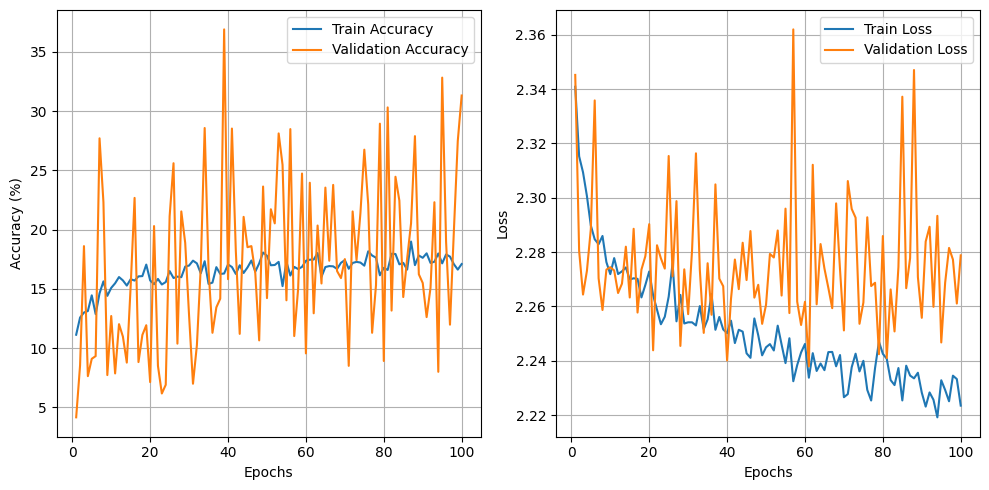

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v5/representacion_3/longitud_8/{nombre_modelo}.png')
plt.show()

***Cargar el modelo :***

In [10]:
#modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)

modelo.load_state_dict(torch.load("./Modelos/v5/representacion_3/longitud_8/ConvNext_Tiny_fold_4.pth"))
modelo.to(device)
modelo.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

***Evaluar el modelo :***

In [11]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

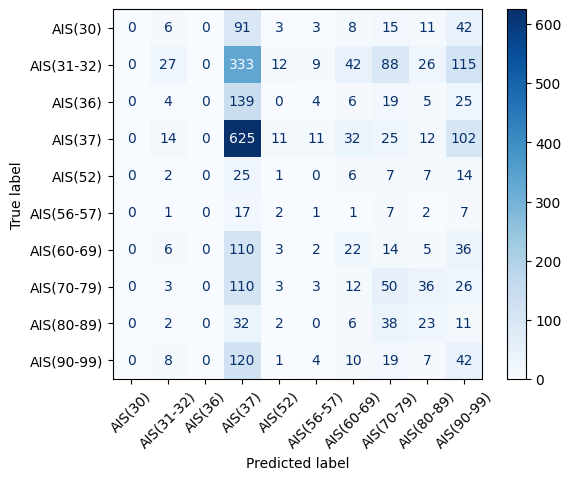

In [12]:
class_names = ['AIS(30)','AIS(31-32)','AIS(36)','AIS(37)','AIS(52)','AIS(56-57)','AIS(60-69)','AIS(70-79)','AIS(80-89)','AIS(90-99)']
#class_names = ['Cargo', 'Fishing', 'Military', 'Sailing', 'Tanker']
#class_names = ['Cargo','Container','Cruise','Fishing','Tanker']
#class_names = ['Cargo', 'Container','Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [13]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v5/representacion_3/longitud_8')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'ConvNext_Tiny_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

     AIS(30)       0.00      0.00      0.00       179
  AIS(31-32)       0.37      0.04      0.07       652
     AIS(36)       0.00      0.00      0.00       202
     AIS(37)       0.39      0.75      0.51       832
     AIS(52)       0.03      0.02      0.02        62
  AIS(56-57)       0.03      0.03      0.03        38
  AIS(60-69)       0.15      0.11      0.13       198
  AIS(70-79)       0.18      0.21      0.19       243
  AIS(80-89)       0.17      0.20      0.19       114
  AIS(90-99)       0.10      0.20      0.13       211

    accuracy                           0.29      2731
   macro avg       0.14      0.16      0.13      2731
weighted avg       0.25      0.29      0.22      2731



c:\Users\jesus\OneDrive\Escritorio\TFG\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jesus\OneDrive\Escritorio\TFG\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jesus\OneDrive\Escritorio\TFG\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i